# CS6140 Final Project Proposal: Walkability Index
### Team Members: James Fan, James Florez, Dominic Cauteruccio, Sara Spasojevic


## Step 0: Notebook Prep


In [3]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

## Step 1: Data Preprocessing and Analysis

#### Load Data

In [5]:
data_url = "https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
raw_df = pd.read_csv(data_url, sep=",", header=0)
raw_df.head()



,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,AutoOwn0,Pct_AO0,AutoOwn1,Pct_AO1,AutoOwn2p,Pct_AO2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,R_PCTLOWWAGE,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E8_Ret,E8_off,E8_Ind,E8_Svc,E8_Ent,E8_Ed,E8_Hlth,E8_Pub,E_LowWageWk,E_MedWageWk,E_HiWageWk,E_PctLowWage,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D1C5_IND,D1C5_SVC,D1C5_ENT,D1C8_RET,D1C8_OFF,D1C8_IND,D1C8_SVC,D1C8_ENT,D1C8_ED,D1C8_HLTH,D1C8_PUB,D1D,D1_FLAG,D2A_JPHH,D2B_E5MIX,D2B_E5MIXA,D2B_E8MIX,D2B_E8MIXA,D2A_EPHHM,D2C_TRPMX1,D2C_TRPMX2,D2C_TRIPEQ,D2R_JOBPOP,D2R_WRKEMP,D2A_WRKEMP,D2C_WREMLX,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,D3BPO4,D4A,D4B025,D4B050,D4C,D4D,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,73.595028,0.0,73.595028,73.595028,1202,460.0,423.0,0.549,69,0.163121,39,0.092199,315,0.744681,412,99,122,191,0.240291,66,20,3,0,19,24,20,3,0,15,24,0,4,0,21,27,18,0.318182,6.250422,16.332625,0.896800,0.271757,0.040764,0.000000,0.258170,0.326109,0.271757,0.040764,0.000000,0.203818,0.326109,0.000000,0.054351,0.0,7.147222,0,0.156028,0.886264,0.763386,0.855442,0.662091,0.348912,0.526296,0.585916,0.287128,0.104101,0.276151,6.242424,5.287423e-03,23.534900,0.000000,10.655277,12.879623,115.981747,0.000000,60.873677,8.696240,34.784958,43.481198,362.10,0.0,0.000000,4.33,37.654717,0.003602,433601,303660,135362,53504,0.000398,0.785893,0.000358,0.841299,0.000525,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831
1,2,4.811300e+11,4.811300e+11,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.829909,0.0,119.829909,119.214200,710,409.0,409.0,0.466,0,0.000000,168,0.410758,241,0.589242,395,76,107,212,0.192405,25,7,0,3,15,0,7,0,3,13,0,0,2,0,10,4,11,0.400000,3.430799,5.955666,0.209707,0.058718,0.000000,0.025165,0.125824,0.000000,0.058718,0.000000,0.025165,0.109047,0.000000,0.000000,0.016777,0.0,3.640506,0,0.061125,0.835015,0.569986,0.831686,0.554458,0.197047,0.248481,0.271309,0.002033,0.068027,0.119048,15.800000,3.736300e-07,22.893366,0.755137,2.859482,19.278747,80.145600,5.340904,10.681807,10.681807,85.454458,5.340904,718.84,0.0,0.009516,4.33,23.126113,0.006099,386504,272135,236885,90089,0.000355,0.700531,0.000321,0.753958,0.000919,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466
2,3,4.811300e+11,4.811300e+11,48,113,7825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,26.367053,0.0,26.367053,26.367050,737,365.0,329.0,0.811,19,0.057751,143,0.434650,167,0.507599,463,136,189,138,0.293737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,13.843035,27.951553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.843035,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367879,0.000000,1.000000,0.000000,0.000000e+00,14.210509,6.128365,2.611430,5.470714,24.272717,24.272717,0.000000,24.272717,0.000000,0.000000,398.31,0.0,0.000000,3.00,72.818150,0.004071,404573,288925,230587,82815,0.000371,0.733281,0.000340,0.800475,0.000894,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281
3,4,4.811300e+11,4.811300e+11,48,113,7824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.060687,0.0,119.060687,119.060687,904,384.0,384.0,0.638,0,0.000000,43,0.111979,341,0.888021,431,60,69,302,0.139211,253,26,0,25,47,155,26,0,25,3,155,2,42,0,121,87,45,0.478261,3.225246,7.592767,2.124967,0.218376,0.000000,0.209977,0.394757,1.301857,0.218376,0.000000,0.209977,0.025197,1.301857,0.016798,0.352761,0.0,5

#### Describe Data

In [6]:
# get column types
raw_df.dtypes

OBJECTID          int64
GEOID10         float64
GEOID20         float64
STATEFP           int64
COUNTYFP          int64
TRACTCE           int64
BLKGRPCE          int64
CSA             float64
CSA_Name         object
CBSA            float64
CBSA_Name        object
CBSA_POP          int64
CBSA_EMP          int64
CBSA_WRK          int64
Ac_Total        float64
Ac_Water        float64
Ac_Land         float64
Ac_Unpr         float64
TotPop            int64
CountHU         float64
HH              float64
P_WrkAge        float64
AutoOwn0          int64
Pct_AO0         float64
AutoOwn1          int64
Pct_AO1         float64
AutoOwn2p         int64
Pct_AO2p        float64
Workers           int64
R_LowWageWk       int64
R_MedWageWk       int64
R_HiWageWk        int64
R_PCTLOWWAGE    float64
TotEmp            int64
E5_Ret            int64
E5_Off            int64
E5_Ind            int64
E5_Svc            int64
E5_Ent            int64
E8_Ret            int64
E8_off            int64
E8_Ind          

In [7]:
# describe numeric variables
raw_df.describe()

,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,AutoOwn0,Pct_AO0,AutoOwn1,Pct_AO1,AutoOwn2p,Pct_AO2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,R_PCTLOWWAGE,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E8_Ret,E8_off,E8_Ind,E8_Svc,E8_Ent,E8_Ed,E8_Hlth,E8_Pub,E_LowWageWk,E_MedWageWk,E_HiWageWk,E_PctLowWage,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D1C5_IND,D1C5_SVC,D1C5_ENT,D1C8_RET,D1C8_OFF,D1C8_IND,D1C8_SVC,D1C8_ENT,D1C8_ED,D1C8_HLTH,D1C8_PUB,D1D,D1_FLAG,D2A_JPHH,D2B_E5MIX,D2B_E5MIXA,D2B_E8MIX,D2B_E8MIXA,D2A_EPHHM,D2C_TRPMX1,D2C_TRPMX2,D2C_TRIPEQ,D2R_JOBPOP,D2R_WRKEMP,D2A_WRKEMP,D2C_WREMLX,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,D3BPO4,D4A,D4B025,D4B050,D4C,D4D,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
count,220740.000000,2.207390e+05,2.207400e+05,220740.000000,220740.000000,220740.000000,220740.000000,167709.000000,203645.000000,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,220740.000000,220465.000000,220465.000000,220740.00000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220469.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220135.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220739.000000,220739.000000,2.207400e+05,220740.000000,2.207400e+05,2.207400e+05,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,2.207400e+05,2.207400e+05
mean,110370.500000,2.870894e+11,2.870915e+11,28.623190,85.697449,262342.382110,2.221392,341.742661,30514.836210,3.607329e+06,1.683334e+06,1.634950e+06,1.103567e+04,7.807248e+02,1.025494e+04,6.831866e+03,1479.863804,626.014628,548.785989,0.59474,48.126511,0.092874,181.123960,0.328227,318.612186,0.569939,637.816753,146.015815,210.235820,281.565117,0.234514,639.106487,71.185426,87.631625,151.342099,256.042117,72.905219,71.185426,61.957035,151.342099,103.060220,72.905219,58.410977,94.570921,25.674590,146.436255,211.019806,281.650426,0.291936,4.530262,10.428739,3.773612,0.364044,0.669539,0.429176,1.814137,0.496716,0.364044,0.465489,0.429176,0.687320,0.496716,0.432051,0.694767,0.205325,8.298313,0.004399,1.768846,0.646566,0.561669,0.673493,0.531642,0.497576,0.468444,0.491936,0.405238,0.311233,0.425024,8.828999,0.293445,15.768748,0.985778,2.966849,11.816121,78.256064,2.254560,13.752833,8.041011,58.822900,21.807039,-57132.809682,0.029835,0.066813,-54046.836625,-53878.418712,-54053.333252,1.030618e+05,88536.521695,4.413897e+04,1.520207e+02,0.004195,0.431461,0.004195,0.494850,-57326.597590,-57326.486630,-57326.597590,-57326.483325,10.500000,10.500000,10.500000,7.624884,9.541628,1.655970e+04,4.466074e+07
std,63722.293548,1.640746e+11,1.640774e+11,16.386075,98.818946,351403.837442,1.195155,125.700068,10979.471375,5.219925e+06,2.478566e+06,2.400293e+06,1.588982e+05,2.683978e+04,1.488759e+05,4.367872e+04,987.862242,383.714541,339.039272,0.10610,83.669015,0.136020,14

In [8]:
# describe categorical variables
raw_df.describe(include='object')

,CSA_Name,CBSA_Name
count,167709,203645
unique,175,938
top,"New York-Newark, NY-NJ-CT-PA","New York-Newark-Jersey City, NY-NJ-PA"
freq,16813,14376


In [9]:
# show null values
print(raw_df.isnull().sum())

OBJECTID            0
GEOID10             1
GEOID20             0
STATEFP             0
COUNTYFP            0
TRACTCE             0
BLKGRPCE            0
CSA             53031
CSA_Name        53031
CBSA            17095
CBSA_Name       17095
CBSA_POP            0
CBSA_EMP            0
CBSA_WRK            0
Ac_Total            0
Ac_Water            0
Ac_Land             0
Ac_Unpr             0
TotPop              0
CountHU           275
HH                275
P_WrkAge            0
AutoOwn0            0
Pct_AO0             0
AutoOwn1            0
Pct_AO1             0
AutoOwn2p           0
Pct_AO2p            0
Workers             0
R_LowWageWk         0
R_MedWageWk         0
R_HiWageWk          0
R_PCTLOWWAGE        0
TotEmp              0
E5_Ret              0
E5_Off              0
E5_Ind              0
E5_Svc              0
E5_Ent              0
E8_Ret              0
E8_off              0
E8_Ind              0
E8_Svc              0
E8_Ent              0
E8_Ed               0
E8_Hlth   

In [10]:
# Fill categorical variables with "NA"
raw_df[["CSA_Name", "CBSA_Name"]] = raw_df[["CSA_Name", "CBSA_Name"]].fillna("NA")

# Fill numeric categorical variables with -1
raw_df[["GEOID10", "CSA", "CBSA"]] = raw_df[["GEOID10", "CSA", "CBSA"]].fillna(-1)

# fill all other variables with median
raw_df = raw_df.fillna(raw_df.median())

# confirm no more null values
print(raw_df.isnull().sum())

<ipython-input-10-2e6d0727298e>:8: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  raw_df = raw_df.fillna(raw_df.median())


OBJECTID        0
GEOID10         0
GEOID20         0
STATEFP         0
COUNTYFP        0
TRACTCE         0
BLKGRPCE        0
CSA             0
CSA_Name        0
CBSA            0
CBSA_Name       0
CBSA_POP        0
CBSA_EMP        0
CBSA_WRK        0
Ac_Total        0
Ac_Water        0
Ac_Land         0
Ac_Unpr         0
TotPop          0
CountHU         0
HH              0
P_WrkAge        0
AutoOwn0        0
Pct_AO0         0
AutoOwn1        0
Pct_AO1         0
AutoOwn2p       0
Pct_AO2p        0
Workers         0
R_LowWageWk     0
R_MedWageWk     0
R_HiWageWk      0
R_PCTLOWWAGE    0
TotEmp          0
E5_Ret          0
E5_Off          0
E5_Ind          0
E5_Svc          0
E5_Ent          0
E8_Ret          0
E8_off          0
E8_Ind          0
E8_Svc          0
E8_Ent          0
E8_Ed           0
E8_Hlth         0
E8_Pub          0
E_LowWageWk     0
E_MedWageWk     0
E_HiWageWk      0
E_PctLowWage    0
D1A             0
D1B             0
D1C             0
D1C5_RET        0
D1C5_OFF  

#### Isolate Relevant Columns

In [11]:
columns = ['CBSA_POP', 'CBSA_EMP', 'CBSA_WRK', 'Ac_Total', 'Ac_Land', \
           'Ac_Unpr', 'TotPop', 'CountHU', 'HH', 'AutoOwn0', 'Pct_AO0', \
           'AutoOwn1', 'Pct_AO1', 'AutoOwn2p', 'Pct_AO2p', 'Workers', 'TotEmp',\
           'D1A', 'D1B', 'D1C', 'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC',\
           'D1C5_ENT', 'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', \
           'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB', 'D1D', 'D2C_TRIPEQ',\
           'D3A', 'D3AAO', 'D3AMM', 'D3APO', 'D3B', 'D3BAO', 'D3BMM3', \
           'D3BMM4', 'D3BPO3', 'D3BPO4', 'D4A', 'D4B025', 'D4B050', 'D4C', \
           'D4D', 'D4E', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'D5CR', 'D5CRI', \
           'D5CE', 'D5CEI', 'D5DR', 'D5DRI', 'D5DE', 'D5DEI']

df = raw_df[columns]

In [12]:
df.head()

,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,AutoOwn0,Pct_AO0,AutoOwn1,Pct_AO1,AutoOwn2p,Pct_AO2p,Workers,TotEmp,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D1C5_IND,D1C5_SVC,D1C5_ENT,D1C8_RET,D1C8_OFF,D1C8_IND,D1C8_SVC,D1C8_ENT,D1C8_ED,D1C8_HLTH,D1C8_PUB,D1D,D2C_TRIPEQ,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,D3BPO4,D4A,D4B025,D4B050,D4C,D4D,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI
0,7189384,3545715,3364458,73.595028,73.595028,73.595028,1202,460.0,423.0,69,0.163121,39,0.092199,315,0.744681,412,66,6.250422,16.332625,0.896800,0.271757,0.040764,0.000000,0.258170,0.326109,0.271757,0.040764,0.000000,0.203818,0.326109,0.000000,0.054351,0.0,7.147222,0.287128,23.534900,0.000000,10.655277,12.879623,115.981747,0.000000,60.873677,8.696240,34.784958,43.481198,362.10,0.0,0.000000,4.33,37.654717,0.003602,433601,303660,135362,53504,0.000398,0.785893,0.000358,0.841299,0.000525,0.184697,0.000476,0.137707
1,7189384,3545715,3364458,119.829909,119.829909,119.214200,710,409.0,409.0,0,0.000000,168,0.410758,241,0.589242,395,25,3.430799,5.955666,0.209707,0.058718,0.000000,0.025165,0.125824,0.000000,0.058718,0.000000,0.025165,0.109047,0.000000,0.000000,0.016777,0.0,3.640506,0.002033,22.893366,0.755137,2.859482,19.278747,80.145600,5.340904,10.681807,10.681807,85.454458,5.340904,718.84,0.0,0.009516,4.33,23.126113,0.006099,386504,272135,236885,90089,0.000355,0.700531,0.000321,0.753958,0.000919,0.323221,0.000801,0.231868
2,7189384,3545715,3364458,26.367053,26.367053,26.367050,737,365.0,329.0,19,0.057751,143,0.434650,167,0.507599,463,0,13.843035,27.951553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.843035,0.367879,14.210509,6.128365,2.611430,5.470714,24.272717,24.272717,0.000000,24.272717,0.000000,0.000000,398.31,0.0,0.000000,3.00,72.818150,0.004071,404573,288925,230587,82815,0.000371,0.733281,0.000340,0.800475,0.000894,0.314628,0.000736,0.213146
3,7189384,3545715,3364458,119.060687,119.060687,119.060687,904,384.0,384.0,0,0.000000,43,0.111979,341,0.888021,431,253,3.225246,7.592767,2.124967,0.218376,0.000000,0.209977,0.394757,1.301857,0.218376,0.000000,0.209977,0.025197,1.301857,0.016798,0.352761,0.0,5.350213,0.596351,32.178373,2.208594,9.323547,20.646233,141.604424,21.501640,21.501640,32.252460,134.385248,5.375410,386.24,0.0,0.515377,6.67,35.853984,0.007378,423099,298058,168433,79657,0.000388,0.766859,0.000351,0.825778,0.000653,0.229821,0.000708,0.205018
4,7189384,3545715,3364458,169.927211,169.927211,148.742920,948,343.0,343.0,5,0.014577,67,0.195335,271,0.790087,579,32,2.305992,6.373413,0.215136,0.000000,0.013446,0.067230,0.134460,0.000000,0.000000,0.013446,0.067230,0.127737,0.000000,0.000000,0.006723,0.0,2.521128,0.007903,22.058651,2.289659,3.176070,16.592921,65.307963,3.766319,0.000000,7.532637,75.326370,7.532637,638.37,0.0,0.248922,6.67,25.121345,0.007036,335700,238166,120826,48682,0.000308,0.608450,0.000281,0.659846,0.000469,0.164863,0.000433,0.125296


Exploratory Data Analysis (EDA)

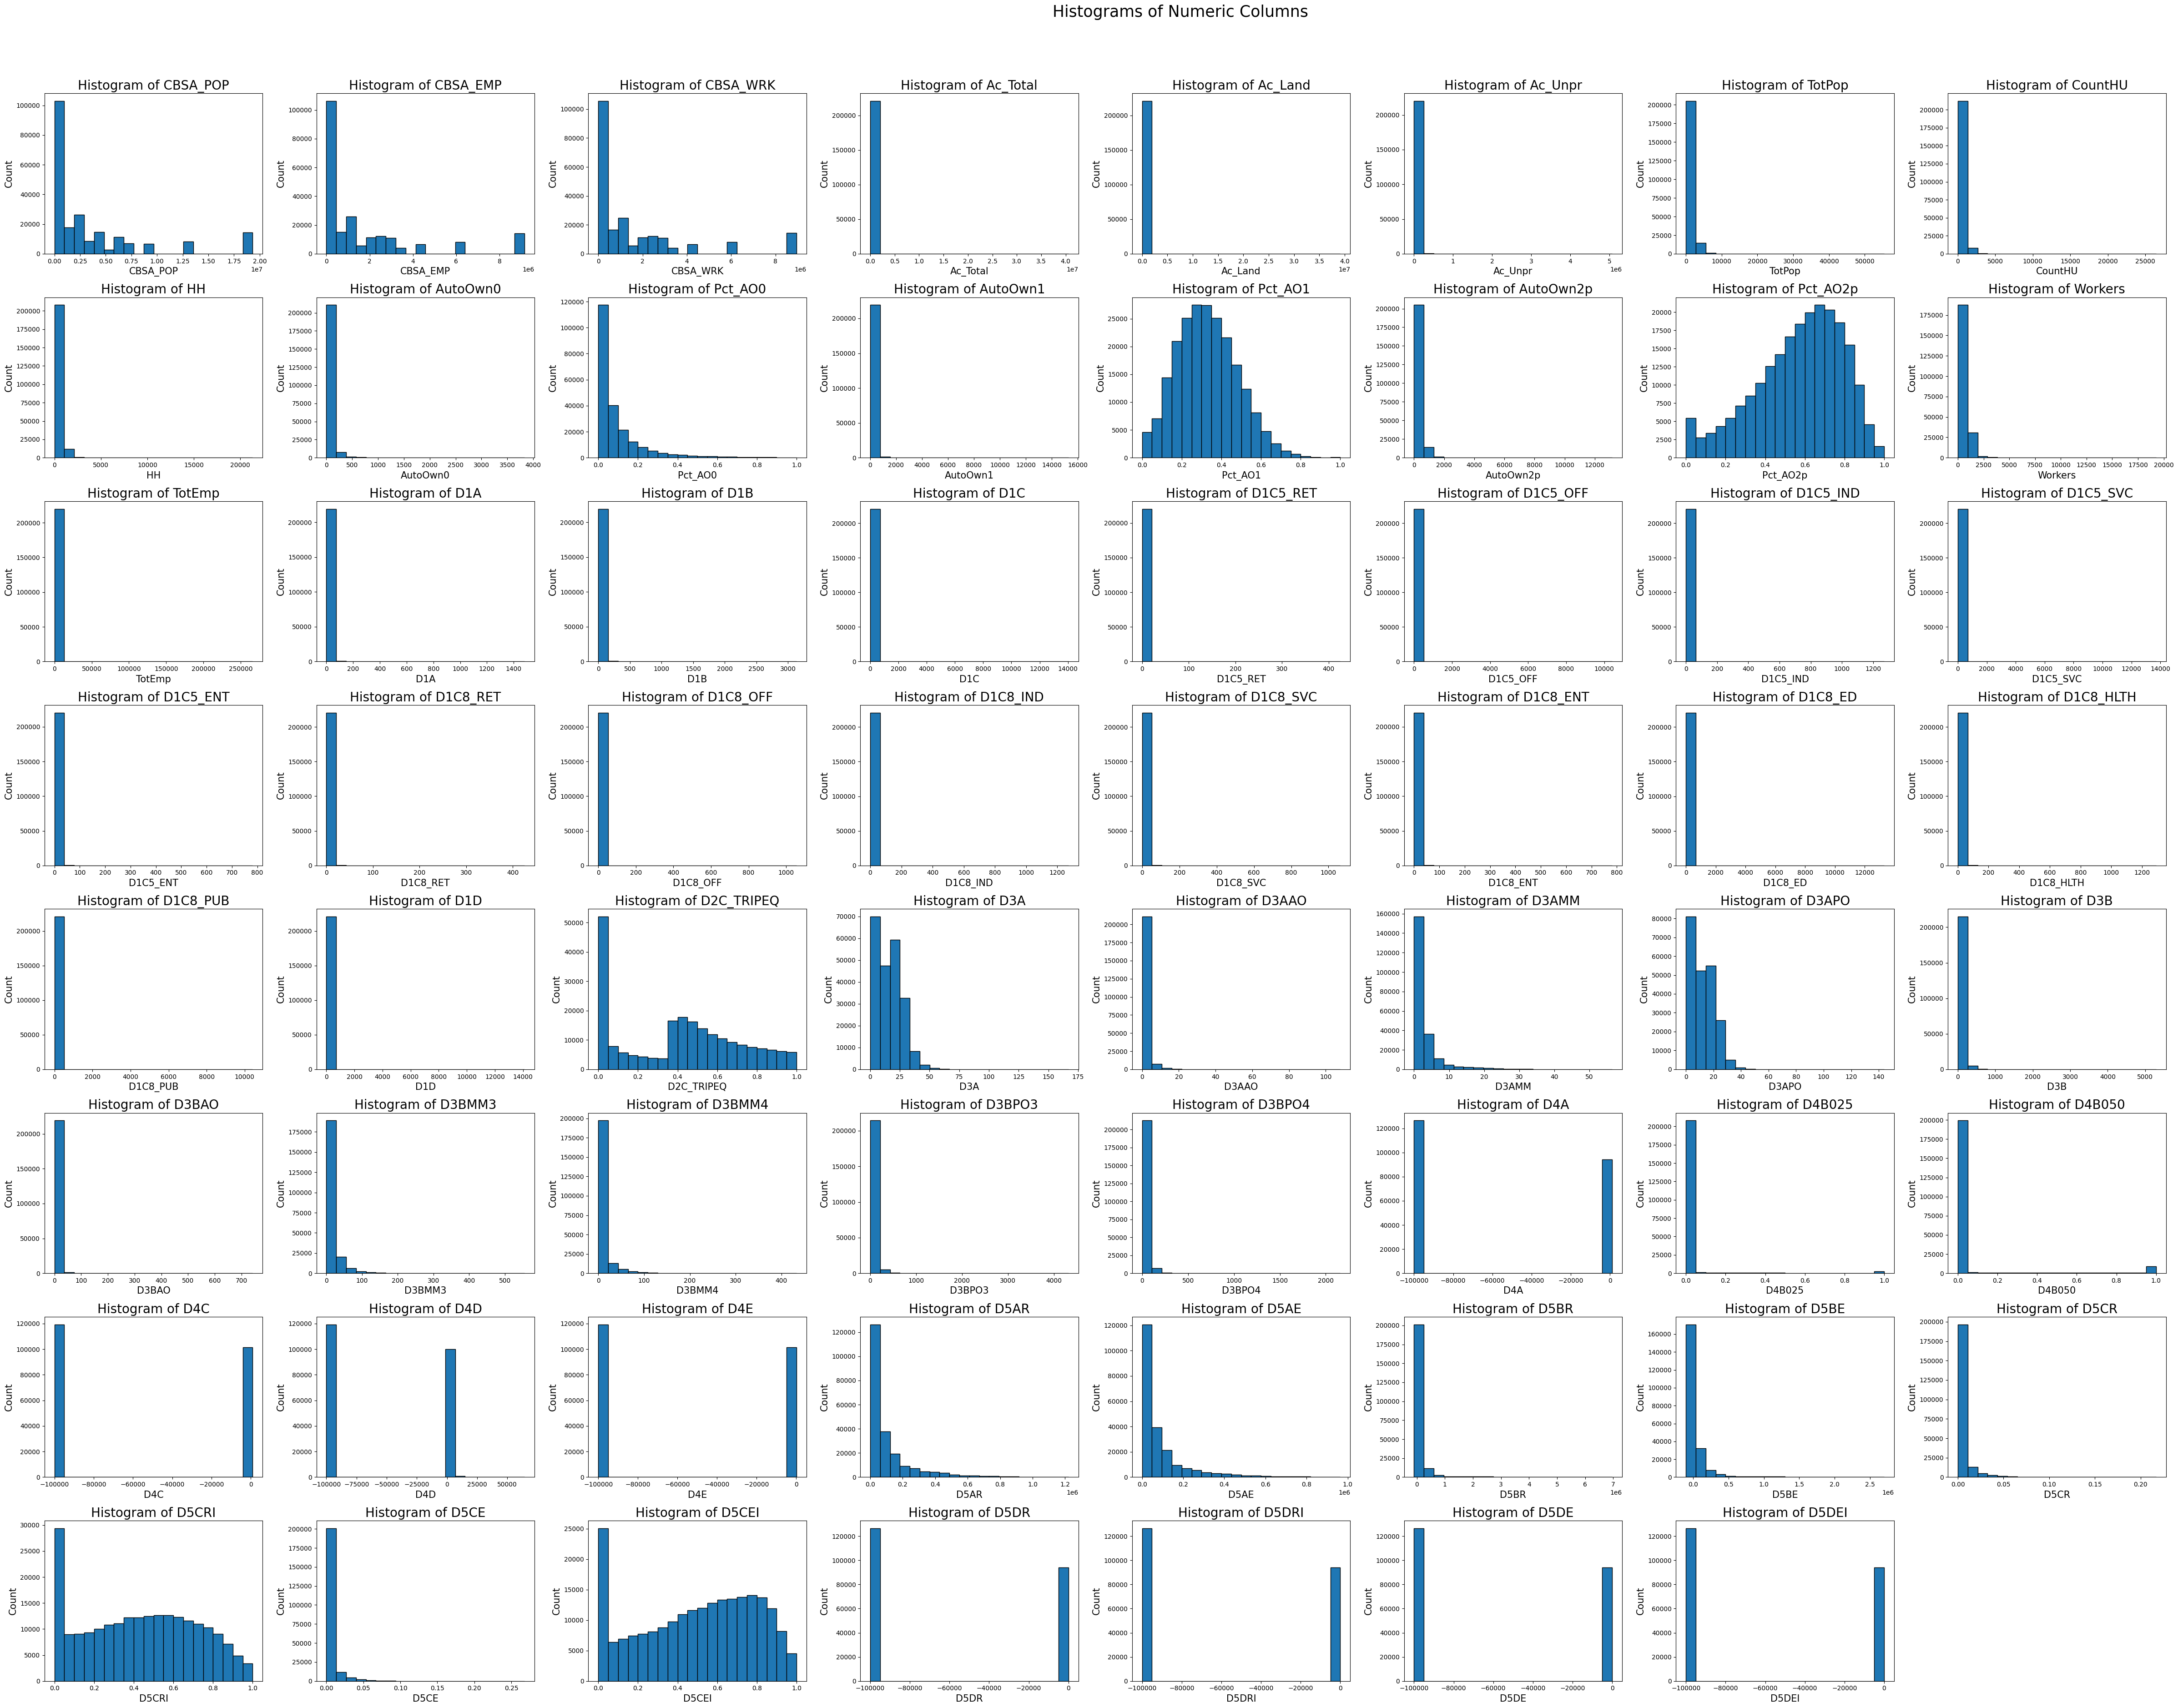

In [13]:
# Univariate Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for selected numeric columns with larger individual plots
plt.figure(figsize=(40, 30))
for i, column in enumerate(df.columns):
    plt.subplot(8, 8, i + 1)
    df[column].hist(bins=20, edgecolor='black', linewidth=1.0, grid=False)
    plt.title(f'Histogram of {column}', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Histograms of Numeric Columns', x=0.65, y=1.25, fontsize=25)
plt.show()


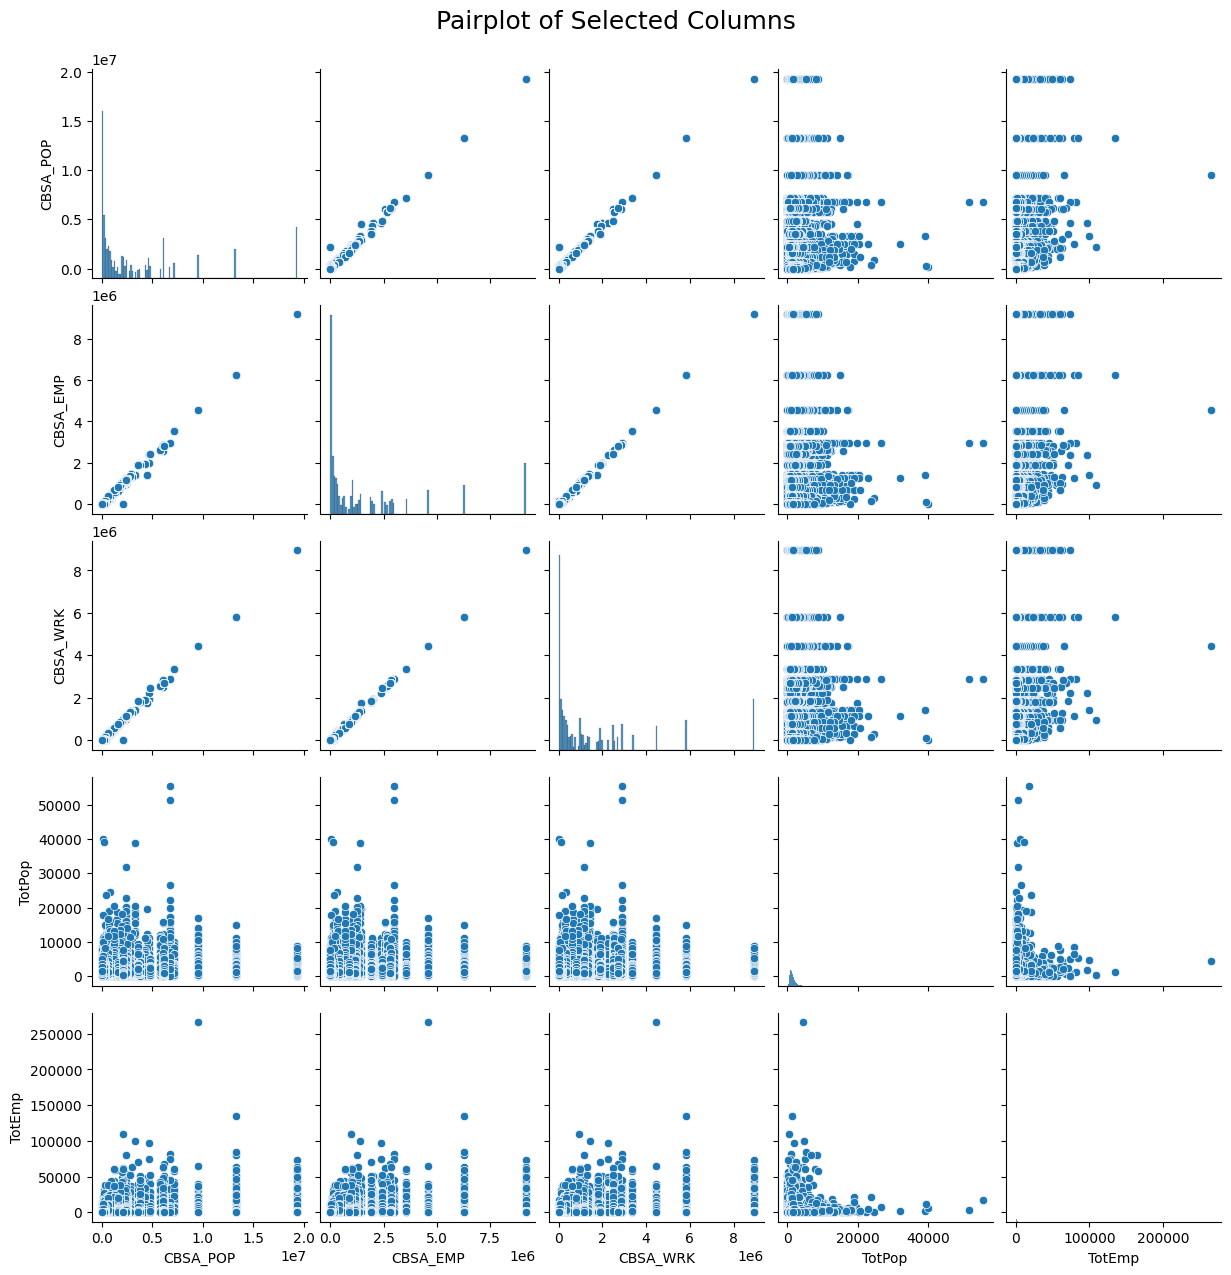

In [15]:
# Bivariate Analysis
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot pairplot for selected columns
sns.pairplot(df[['CBSA_POP', 'CBSA_EMP', 'CBSA_WRK', 'TotPop', 'TotEmp']])
plt.suptitle('Pairplot of Selected Columns', y=1.02, fontsize=18)
plt.show()

#### Principal Components

In [16]:
# Split data into X and Y
X = df
y = raw_df["NatWalkInd"]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize X
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

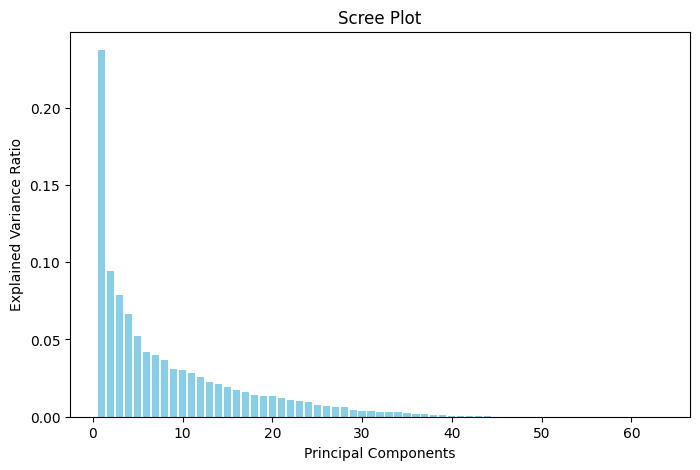

In [17]:
# PCA on the training set
pca = decomposition.PCA()  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(num_components) + 1, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [ ]:
# def pca_eigen(X):
#   '''
#     Function calculates and returns eigenvalues, eigenvectors,
#     and the explained variance for each from the matrix.
#   '''
#   cov_matrix = np.cov(X)
#   eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
#   explained_variances = []
#   for i in range(len(eigen_values)):
#     explained_variances.append(eigen_values[i] / np.sum(eigen_values))
#   return (eigen_values, eigen_vectors, explained_variances)

In [ ]:
# TODO: This code section was causing the session to use all of the available RAM and then crash.

# matrix = df.values
# eigen_values, eigen_vectors, explained_variances = pca_eigen(matrix)

In [ ]:
# print(eigen_vectors.T)